## Read dataset
Please see the [IEEE Data Portal](https://ieee-dataport.org/open-access/dataset-binary-classification-digital-sensor-signals) for the details of this dataset.

In [1]:
import pandas as pd

In [2]:
fp = "../../../data/sensor_data.csv"
df = pd.read_csv(fp, sep=";")
sensor_cols = ["sensor-" + str(i+1) for i in range(10)]
cols = sensor_cols + ["target"]
df.columns = cols

In [3]:
df

,sensor-1,sensor-2,sensor-3,sensor-4,sensor-5,sensor-6,sensor-7,sensor-8,sensor-9,sensor-10,target
0,38.29,38.29,38.29,38.29,38.29,38.29,38.66,38.66,38.66,38.66,1
1,39.03,38.66,39.03,39.03,39.03,39.03,39.03,39.03,39.03,39.03,1
2,39.41,39.41,39.41,39.41,39.41,39.41,39.78,39.41,39.78,39.78,1
3,39.78,39.78,39.78,39.78,40.15,40.15,40.15,40.15,40.15,40.15,1
4,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,1
...,...,...,...,...,...,...,...,...,...,...,...
4470,72.63,72.63,72.63,72.63,72.63,72.63,72.63,72.63,72.89,72.89,1
4471,72.89,72.63,72.63,72.63,72.63,72.63,72.63,72.63,72.63,72.63,1
4472,72.63,72.89,72.63,72.63,72.63,72.63,72.63,72.63,72.63,72.63,1
4473,72.63,72.63,72.63,72.63,72.89,72.89,72.89,72.63,72.63,72.63,1


## Featurization
We will evaluate two featurization schemes:
(1) Using the raw sensor array measurements as is
(2) Featurization using statistical measures: For sensor data, featurizing the signal using various statistical properties of the signal is a common feature engineering idea. Libraries such as [tsfresh](https://tsfresh.readthedocs.io/en/latest/) provide several [feature engineering](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) ideas for sensor data. For this example we will use a very basic featurization scheme that just uses the minimum, maximum, mean and standard deviation of the sensor data array. Results show that this is more than adequete for this purpose.

## Separate out Oil and Water Meaurements

In [4]:
df["target"].value_counts()

target
 1    2569
-1    1906
Name: count, dtype: int64

## Define Featurization

In [5]:
import statistics

df["sd"] = df[sensor_cols].apply(lambda x: statistics.stdev(x) , axis=1)
df["mean"] = df[sensor_cols].apply(lambda x: statistics.mean(x) , axis=1)
df["max"] = df[sensor_cols].apply(lambda x: max(x) , axis=1)
df["min"] = df[sensor_cols].apply(lambda x: min(x) , axis=1)

In [6]:
df_water = df[df.target == 1]

In [7]:
df_oil = df[df.target == -1]

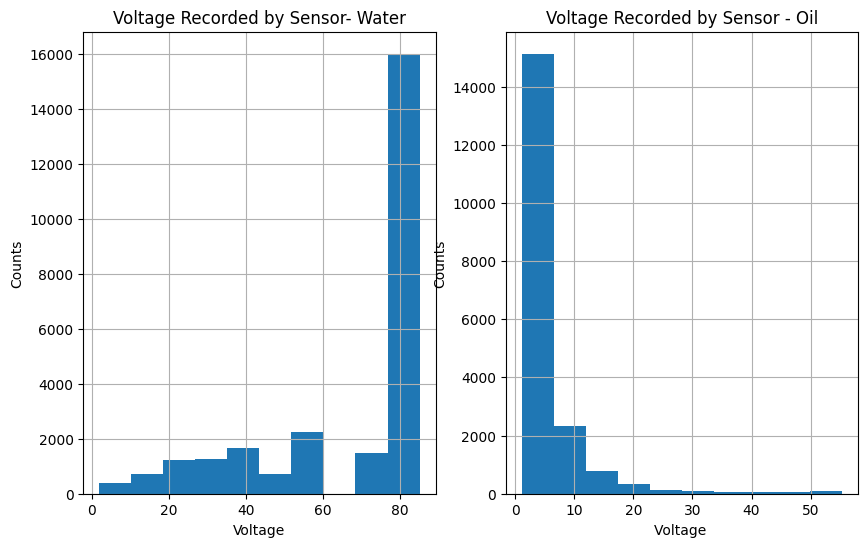

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
water_values = df_water[sensor_cols].values.flatten()
oil_values = df_oil[sensor_cols].values.flatten()
plt.subplot(1,2,1)
_ = plt.hist(water_values)
plt.title("Voltage Recorded by Sensor- Water")
plt.xlabel("Voltage")
plt.ylabel("Counts")
plt.grid()
plt.subplot(1,2,2)
_= plt.hist(oil_values)
plt.title("Voltage Recorded by Sensor - Oil")
plt.xlabel("Voltage ")
plt.ylabel("Counts")
plt.grid()


## Observations
1. The data is from a capacitive sensor array. The voltage builds up to a stable voltage perhaps due to the charging and discharging cycles of the sensor as well as the [physics of the device operation](https://www.researchgate.net/publication/347270525_Real-time_Detection_of_Oil_Viscosity_Using_Coplanar_Capacitive_Sensors).
2. Oil and Water appear to have very distinct voltage levels

In [9]:
feat_ds_cols = ["min","max", "mean", "sd", "target"]
feats = ["min","max", "mean", "sd"]

df_featurized = df[feat_ds_cols]
df_sensor = df[sensor_cols]

In [10]:
df_featurized

,min,max,mean,sd,target
0,38.29,38.66,38.438,0.191067,1
1,38.66,39.03,38.993,0.117004,1
2,39.41,39.78,39.521,0.178727,1
3,39.78,40.15,40.002,0.191067,1
4,40.52,40.52,40.520,0.000000,1
...,...,...,...,...,...
4470,72.63,72.89,72.682,0.109626,1
4471,72.63,72.89,72.656,0.082219,1
4472,72.63,72.89,72.656,0.082219,1
4473,72.63,72.89,72.708,0.125592,1


## Develop a Decision Tree (non-parametric) classifier on both featurization schemes

In [11]:
from sklearn.model_selection import train_test_split
train_feat, test_feat = train_test_split(df_featurized, test_size=0.2)
train_sensor, test_sensor = train_test_split(df_sensor, test_size=0.2)

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
depth_range = [(i) for i in range(2,8)]
nnrange = [i for i in range(3,10)]

In [14]:
X_feat = train_feat[feats]
Y = train_feat["target"]
Xt_feat = test_feat[feats]
Yt = test_feat["target"]
X_sensor = train_sensor[sensor_cols]
Xt_sensor = test_sensor[sensor_cols]

In [15]:
Yt.value_counts()

target
 1    510
-1    385
Name: count, dtype: int64

In [16]:
from sklearn.metrics import accuracy_score
accuracy_test = []
for d in depth_range:
    print("Running experiment for depth {depth}".format(depth=d))
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_feat,Y)
    Ypred_test = clf.predict(Xt_feat)
    acc_at_d = accuracy_score(Yt, Ypred_test)
    accuracy_test.append(acc_at_d)

Running experiment for depth 2
Running experiment for depth 3
Running experiment for depth 4
Running experiment for depth 5
Running experiment for depth 6
Running experiment for depth 7


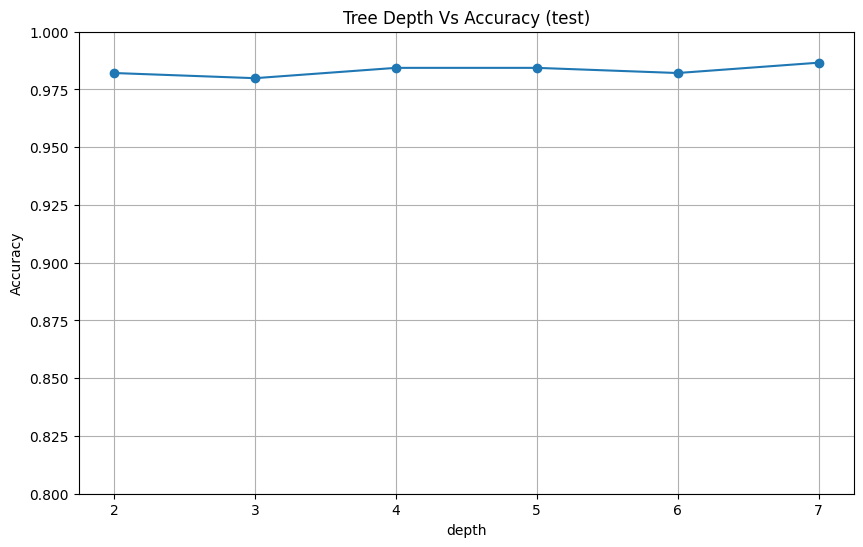

In [17]:
plt.figure(figsize=(10,6))
plt.title("Tree Depth Vs Accuracy (test)")
plt.xlabel("depth")
plt.ylabel("Accuracy")
plt.plot(depth_range, accuracy_test, marker="o")
plt.ylim((.8,1.0))
plt.grid()

## Profile the best performing classifier

In [18]:
BEST_DEPTH = 6
clf = DecisionTreeClassifier(max_depth=BEST_DEPTH)
clf.fit(X_feat,Y)

DecisionTreeClassifier(max_depth=6)

In [19]:
sensor_fe_importance = {}
for name, importance in zip(feats, clf.feature_importances_):
    sensor_fe_importance[name] = importance

In [20]:
dffe = pd.DataFrame.from_dict(sensor_fe_importance, orient="index").reset_index()
dffe.columns = ["feature", "importance"]
dffe

,feature,importance
0,min,0.887460
1,max,0.007156
2,mean,0.006253
3,sd,0.099130


In [21]:
accuracy_test = []
for d in depth_range:
    print("Running experiment for depth {depth}".format(depth=d))
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_sensor,Y)
    Ypred_test = clf.predict(Xt_sensor)
    acc_at_d = accuracy_score(Yt, Ypred_test)
    accuracy_test.append(acc_at_d)

Running experiment for depth 2
Running experiment for depth 3
Running experiment for depth 4
Running experiment for depth 5
Running experiment for depth 6
Running experiment for depth 7


In [22]:
accuracy_test

[0.5687150837988827,
 0.5687150837988827,
 0.5687150837988827,
 0.5698324022346368,
 0.5698324022346368,
 0.5698324022346368]

## Featurization Observations

1. Clearly the featurization scheme with raw features does poorly in terms of dicrimination in comparison the featureset derived from statistical properties.
2. An analysis of the errors shows that there are possible data labelling errors in this dataset. For example you have some rows with voltage values typical of the water voltage level but labeled as oil and vice versa. In other words this dataset appears to have **label noise**.
3. An outlier detection scheme run on the oil and water labels can capture and remove this from the dataset. The cleaned dataset can then be used to develop a classifier. 

In [23]:
BEST_DEPTH = 6
clf = DecisionTreeClassifier(max_depth=BEST_DEPTH)
clf.fit(X_feat,Y)

best_prediction = clf.predict(Xt_feat)
df_test = pd.DataFrame(Xt_sensor)
df_test["prediction"] = best_prediction
df_test["target"] = Yt.values

In [24]:
incorrect = df_test.prediction != df_test.target
df_test[incorrect]

,sensor-1,sensor-2,sensor-3,sensor-4,sensor-5,sensor-6,sensor-7,sensor-8,sensor-9,sensor-10,prediction,target
4068,31.23,31.23,31.40,31.40,31.58,31.75,31.75,31.93,31.93,31.93,1,-1
2196,81.06,81.06,81.06,81.06,81.06,81.06,81.06,80.62,81.06,81.06,1,-1
3419,15.10,15.10,15.10,15.10,15.10,15.10,15.10,15.10,14.93,15.10,1,-1
2520,81.02,81.02,81.02,81.02,81.02,81.02,81.02,81.02,81.02,81.02,-1,1
3415,16.11,16.11,15.94,15.94,15.94,15.94,15.77,15.77,15.77,15.77,-1,1
3876,1.45,1.45,1.45,1.45,1.45,1.45,1.45,1.45,1.45,1.45,1,-1
2071,78.57,78.57,78.57,78.57,78.57,78.57,78.57,78.57,78.57,78.57,1,-1
1714,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,-1,1
2266,81.06,81.06,81.06,81.06,81.06,81.06,81.06,81.06,81.06,81.06,1,-1
596,9.23,9.23,9.23,9.59,9.59,9.23,9.59,9.23,9.23,9.23,-1,1


In [25]:
from kmds.ontology.kmds_ontology import *
from kmds.tagging.tag_types import DataRepresentationTags, ExploratoryTags

kaw = KnowledgeExtractionExperimentationWorkflow("sensor_data_feature_profile", namespace=onto)

In [26]:
from kmds.ontology.intent_types import IntentType
exp_obs_list = []
observation_count = 1
exp1 = ExploratoryObservation(namespace=onto)
exp1.finding = "Oil and Water have very distinct voltage recordings on the sensor. It looks like there is good\
separation (except for label noise) for this dataset. Voltage build up on the sensor has an exponential type\
behavior due to the physics of the process and the capacitive nature of the sensor."
exp1.finding_sequence = observation_count
exp1.exploratory_observation_type = ExploratoryTags.DATA_QUALITY_OBSERVATION.value
exp1.intent = IntentType.DATA_UNDERSTANDING.value
exp_obs_list.append(exp1)

observation_count += 1
exp2 = ExploratoryObservation(namespace=onto)
exp2.finding = "Analysis of the classifier errors revealed that there is likely some label noise in the data. These can be identified,\
by running an outlier analysis (for example, with the IsolationForest algorithm) to identify outliers. The classifier should be developed.\
after removing the label noise."
exp2.finding_sequence = observation_count
exp2.exploratory_observation_type = ExploratoryTags.DATA_QUALITY_OBSERVATION.value
exp2.intent = IntentType.DATA_UNDERSTANDING.value
exp_obs_list.append(exp2)

observation_count += 1
exp3 = ExploratoryObservation(namespace=onto)
exp3.finding = "A non parametric method, decision tree was used for the feature profiling, but, since there is good separation,\
a hyperplane classifier should also work well. The contributors of this dataset have used an SVM for example."
exp3.finding_sequence = observation_count
exp3.exploratory_observation_type = ExploratoryTags.DATA_QUALITY_OBSERVATION.value
exp3.intent = IntentType.DATA_UNDERSTANDING.value
exp_obs_list.append(exp3)

kaw.has_exploratory_observations = exp_obs_list


In [27]:

dr_obs_list = []
observation_count = 1

dr1 = DataRepresentationObservation(namespace=onto)
dr1.finding = "Two featurization schemes are evaluated (1) With raw features (2) Featurization with statistical signal properties"
dr1.finding_sequence = observation_count
dr1.data_representation_observation_type = DataRepresentationTags.FEATURE_ENGG_OBSERVATION.value
dr1.intent = IntentType.FEATURE_ASSESSMENT.value
dr_obs_list.append(dr1)

observation_count += 1
dr2 = DataRepresentationObservation(namespace=onto)
dr2.finding = "The featurization scheme with the statistical properties performs better."
dr2.finding_sequence = observation_count
dr2.data_representation_observation_type = DataRepresentationTags.FEATURE_ENGG_OBSERVATION.value
dr2.intent = IntentType.FEATURE_ASSESSMENT.value
dr_obs_list.append(dr2)

observation_count += 1
dr3 = DataRepresentationObservation(namespace=onto)
dr3.finding = "The minimum volatage value recorded by the sensor has the most discriminative power."
dr3.finding_sequence = observation_count
dr3.data_representation_observation_type = DataRepresentationTags.FEATURE_ENGG_OBSERVATION.value
dr3.intent = IntentType.FEATURE_ASSESSMENT.value
dr_obs_list.append(dr3)


In [28]:
kaw.has_data_representation_observations = dr_obs_list
KNOWLEDGE_BASE = "sensor_data_feature_profile.xml"
onto.save(KNOWLEDGE_BASE)